# EU emails

This is an analysis on the EU emails core dataset from SNAP.

https://snap.stanford.edu/data/email-Eu-core.html

This dataset contains ground truth communities of 42 EU departments, varying in size.

## Refrences

    Hao Yin, Austin R. Benson, Jure Leskovec, and David F. Gleich. "Local Higher-order Graph Clustering." In Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. 2017.
    
    
    J. Leskovec, J. Kleinberg and C. Faloutsos. Graph Evolution: Densification and Shrinking Diameters. ACM Transactions on Knowledge Discovery from Data (ACM TKDD), 1(1), 2007.


In [1]:
%matplotlib inline
import networkx as nx
import cluster_query_tool
lfr = nx.community.community_generators.LFR_benchmark_graph
from subprocess import check_output
import networkx as nx
from collections import defaultdict
import numpy as np
from collections import defaultdict
from cluster_query_tool.louvain_consensus import mu_ivector
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_recall_curve, average_precision_score
import os
import seaborn as sns

In [2]:
graph = nx.Graph()
with open("../data/eu_email/network.txt") as network:
    edges = []
    for line in network:
        dt = line.strip().split()
        edges.append((int(dt[0]), int(dt[1])))

graph.add_edges_from(edges)

graph = [graph.subgraph(c).copy() for c in nx.connected_components(graph)][0]

comms = defaultdict(list)

with open("../data/eu_email/communities.txt") as cfile:
    for line in cfile:
        dt = line.strip().split()
        if int(dt[0]) in graph.nodes():
            comms[int(dt[1])].append(int(dt[0]))
        
graph.name = "eu_emails_core"



In [3]:
# Generate an index
from cluster_query_tool import indexer

print(graph.name, len(comms))
index = indexer.get_index(graph)
print(graph.number_of_nodes(), graph.number_of_edges(), "{:.3f}".format(nx.density(graph)))

eu_emails_core 42
986 16687 0.034


In [4]:
from scipy.special import binom
import itertools

def unique_sampler(node_set, sample_size, max_samples=120):
    sample_sets = set()
    
    # maximum number of samples
    sspace = binom(len(node_set), sample_size)
    if sspace > max_samples:
        
        if sspace > max_samples * 2:
            # problem with this loop is when max_samples is close to n choose k
            while len(sample_sets) < max_samples:
                samp = tuple(sorted(np.random.choice(node_set, sample_size, replace=False)))
                sample_sets.add(samp)
        else:
            # Generate max_samples, unique random numbers sampling without replacement from possible combinations
            # Faster than above loop in case where n choose k is close to max_samples
            sp = np.random.choice(range(int(binom(len(node_set), sample_size))), max_samples, replace=False)
            poss = list(itertools.combinations(node_set, sample_size))
            for s in  sp:
                sample_sets.add(poss[s])
            
    else:
        sample_sets = set(itertools.combinations(node_set, sample_size))
    
    return sample_sets

Here is the first test. Calculate roc curves and auc scores for 3 randomly chosen nodes from each community.
Communities with 3 or less nodes are skipped.

Recovery of communites is very high for most networks $auc > 0.8$ with a starting set of only 3 nodes.

/home/mbzjpg/c2q/venv/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


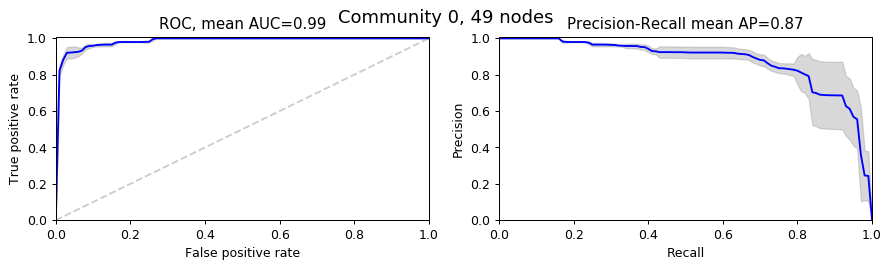

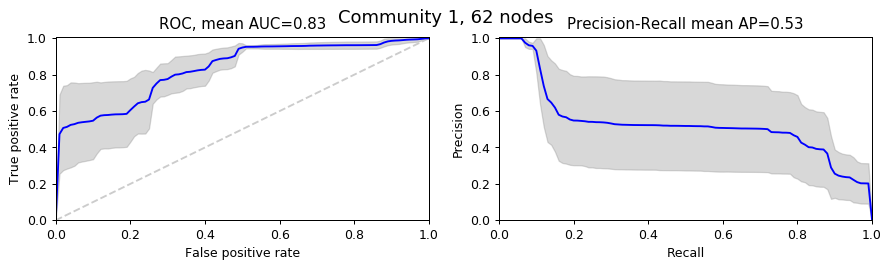

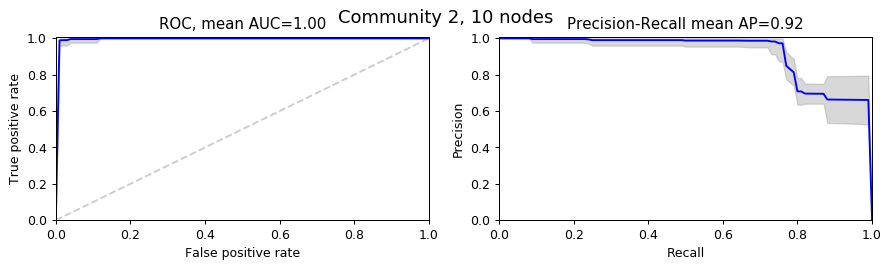

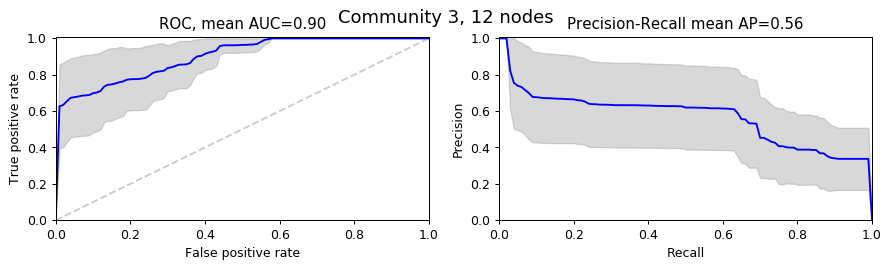

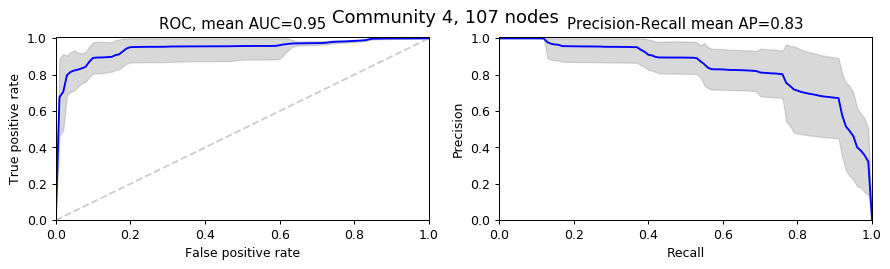

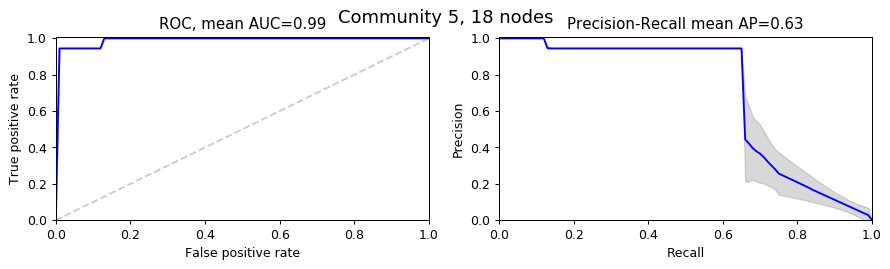

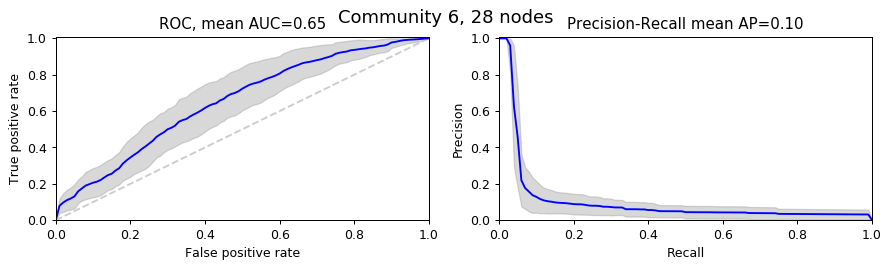

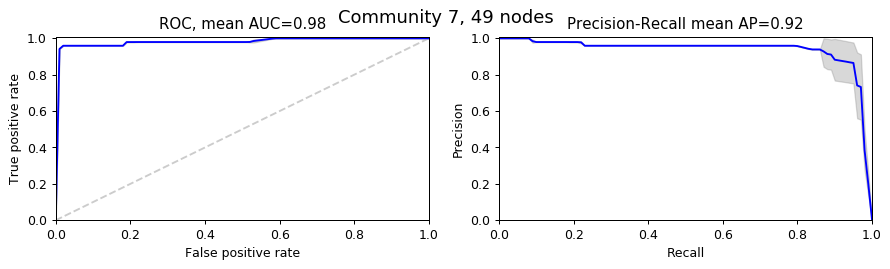

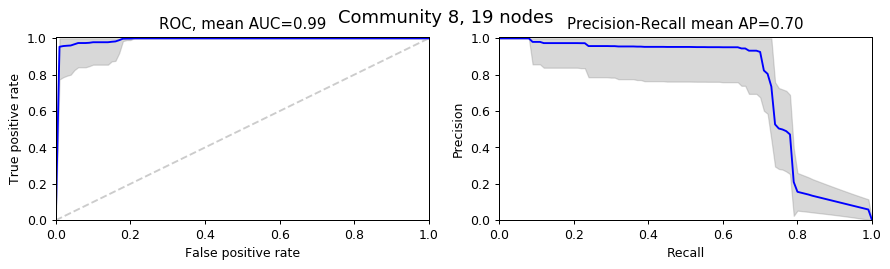

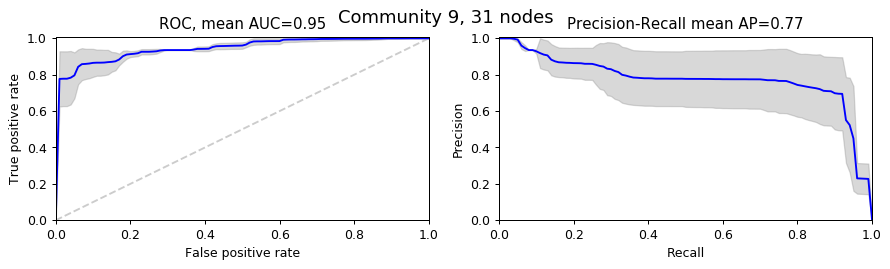

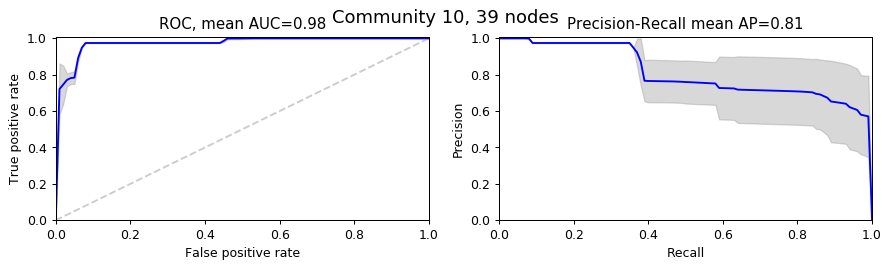

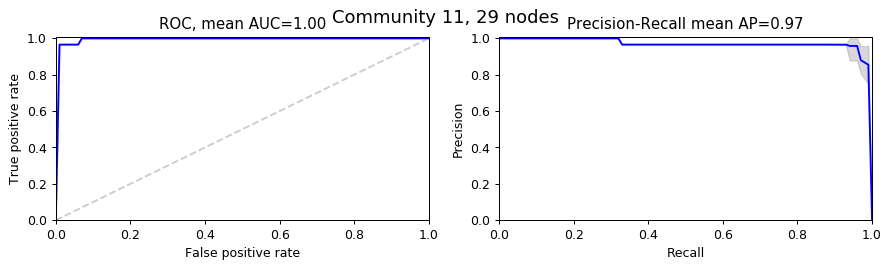

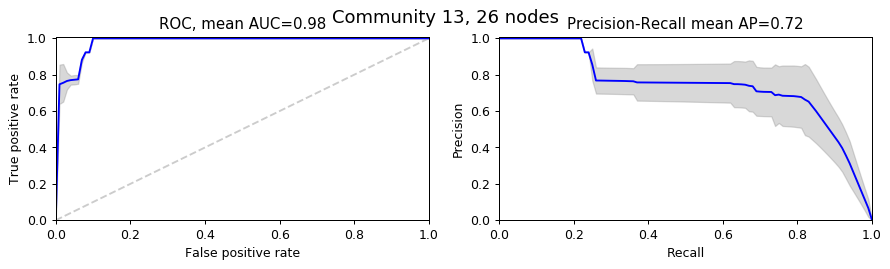

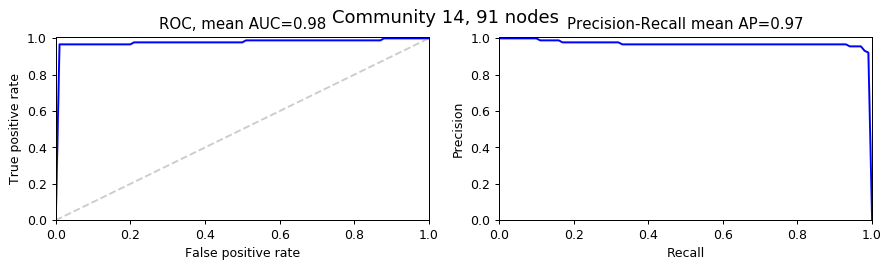

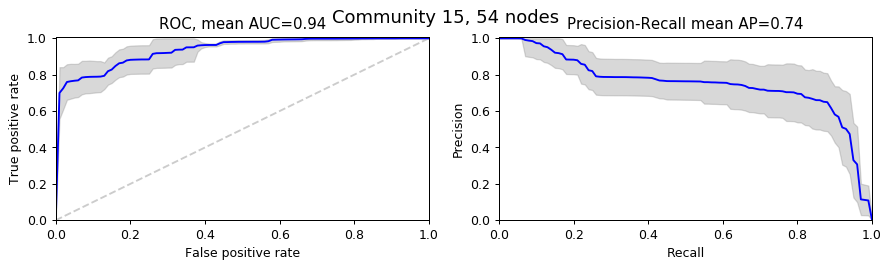

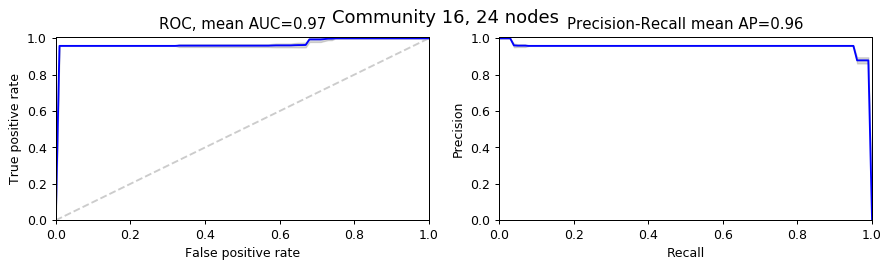

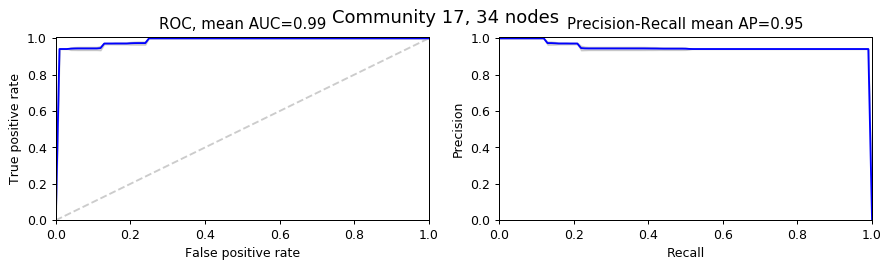

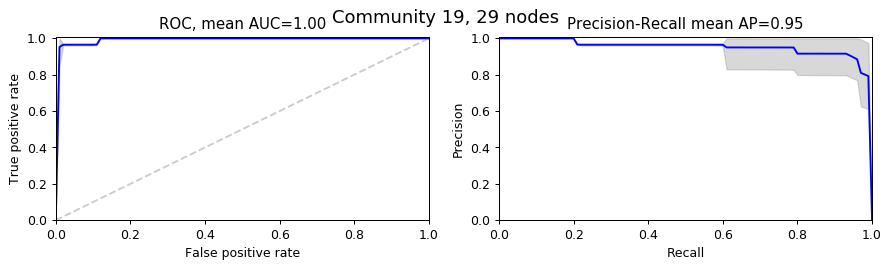

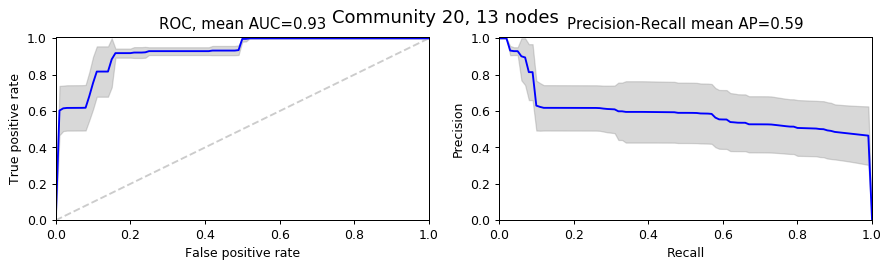

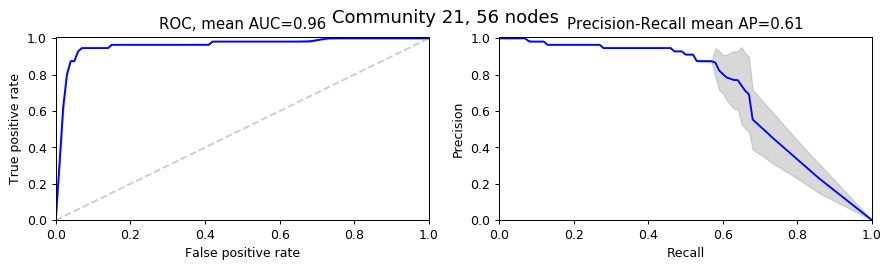

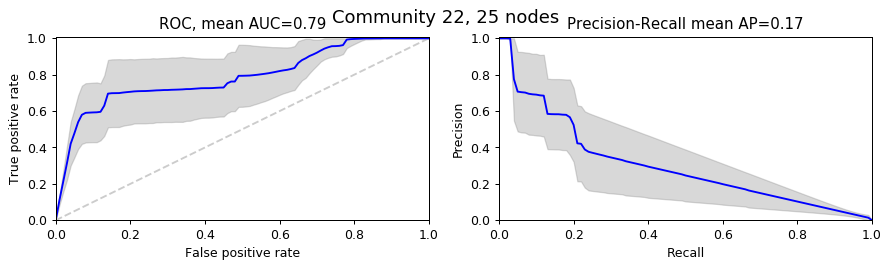

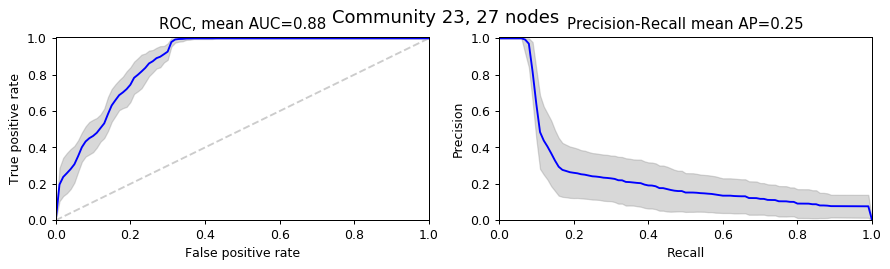

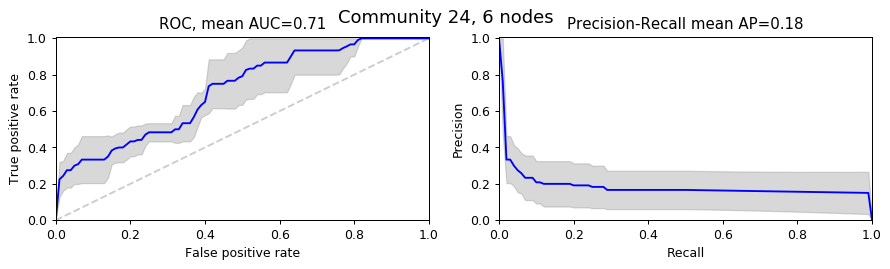

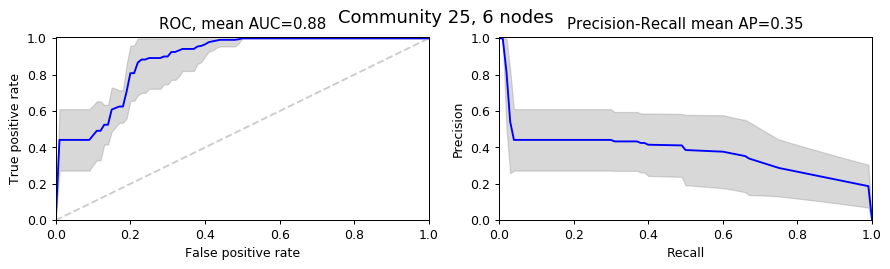

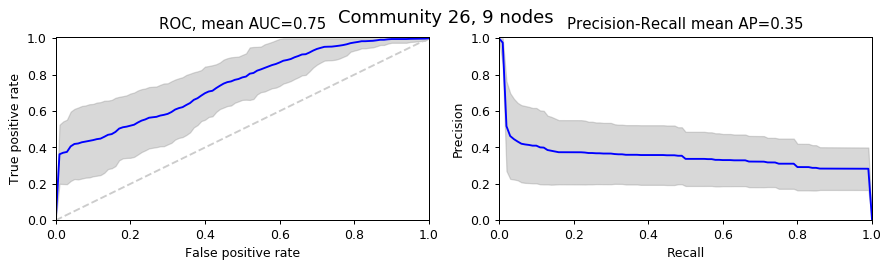

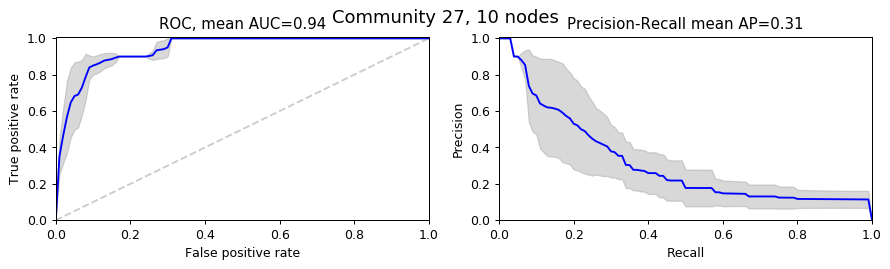

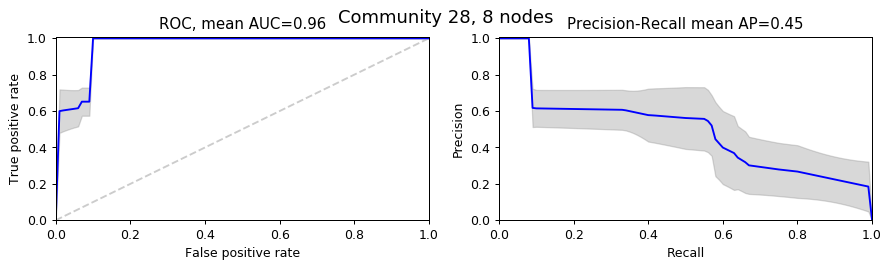

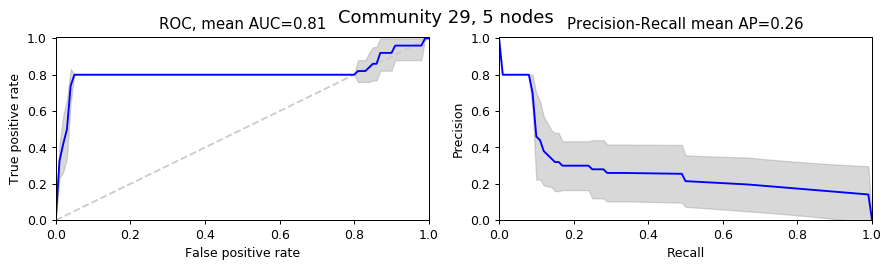

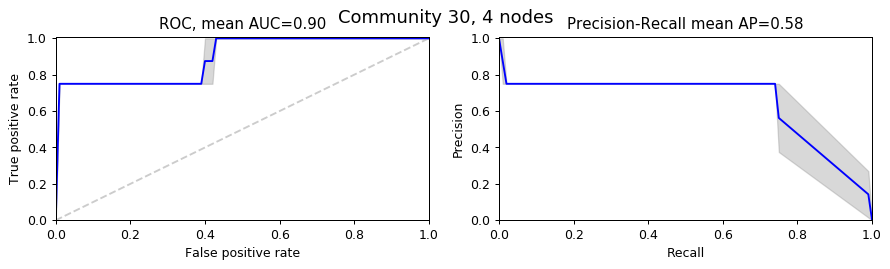

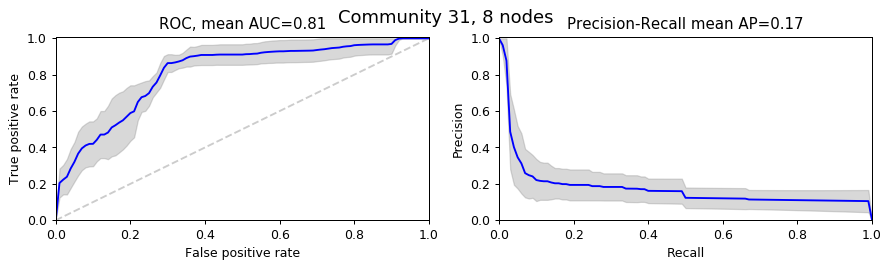

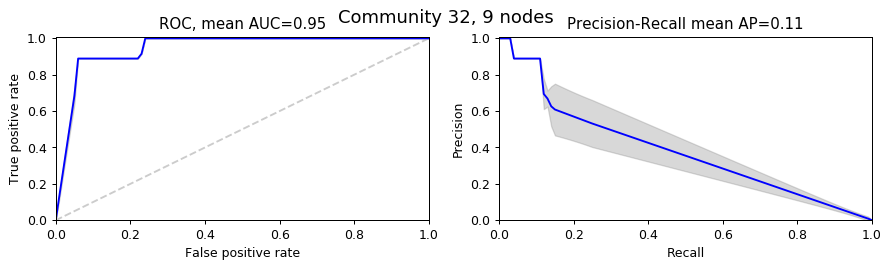

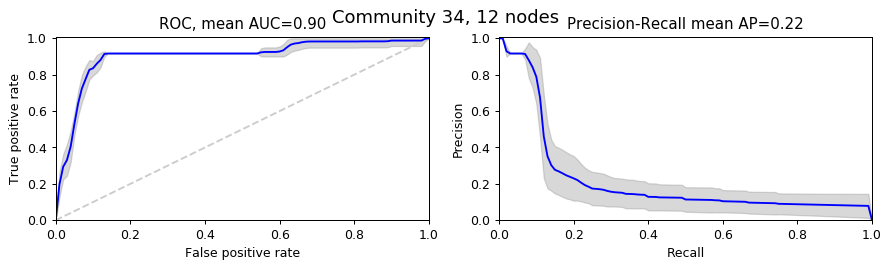

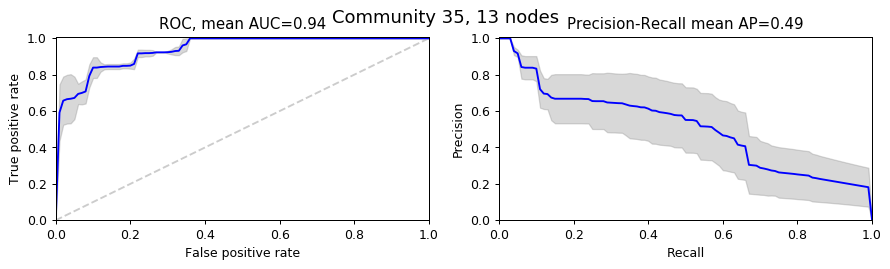

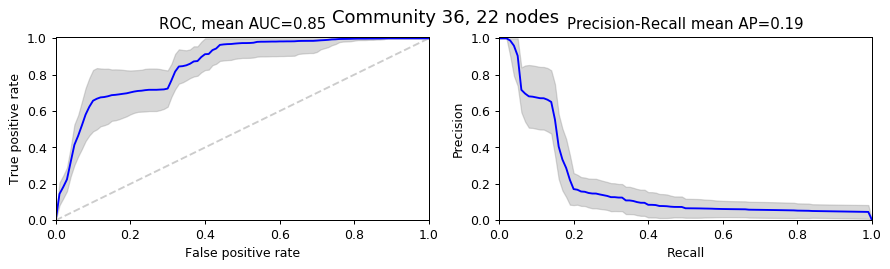

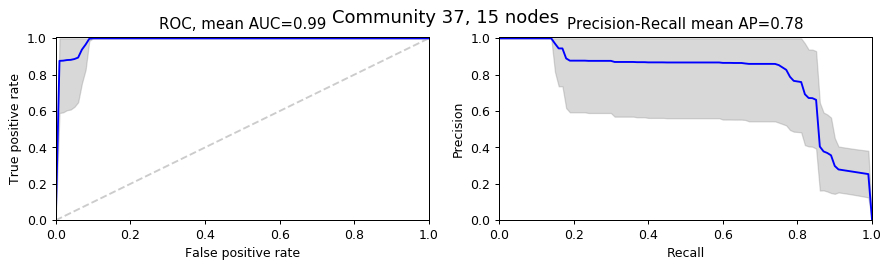

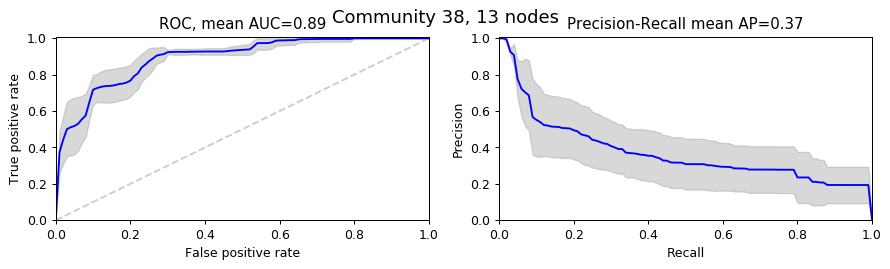

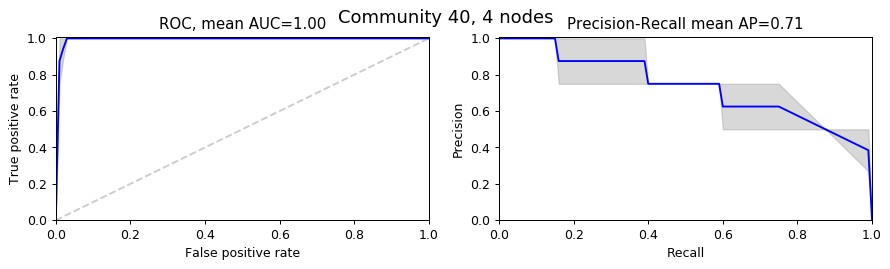

In [25]:
from scipy import interp

seed_size = 3
samples = 120

auc_scores = dict()
app_scores = dict()

for c in sorted(comms.keys()):

    if len(comms[c]) <= seed_size:
        continue
    
    plt.figure(c)
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_dpi(90)
    fig.set_size_inches(10, 3)
    fig.suptitle("Community {}, {} nodes".format(c, len(comms[c])), fontsize="x-large")
    
    auc_scores[c] = []
    app_scores[c] = []
    
   
    axes[0].set_xlabel("False positive rate")
    axes[0].set_ylabel("True positive rate")

    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.01])
    
    
    axes[1].set_ylabel("Precision")
    axes[1].set_xlabel("Recall")
    
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.01])
    
    axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), '--', color="#cccccc")
    
    
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    
    presc = []
    base_pr = np.linspace(0, 1, 101)
    
    sampled_sets = unique_sampler(comms[c], seed_size, max_samples=samples)
    vecs = Parallel(n_jobs=24) ( delayed(mu_ivector)(graph, index, cs) for cs in sampled_sets)
    
    for vec, key in vecs:
        inc = lambda x: 1 if x in comms[c] else 0
        y_true = [inc(x) for x in graph.nodes()]
        y_score = [vec[key[x]] for x in graph.nodes()]
        
        
        auc_scores[c].append(roc_auc_score(y_true, y_score))
        app_scores[c].append(average_precision_score(y_true, y_score))
        
        fpr, tpr, _ = roc_curve(y_true, y_score)
        
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr) 

        precision, recall, _ = precision_recall_curve(y_true, y_score)
        
        tpr = interp(base_pr, precision, recall)
        tpr[0] = 1.0
        presc.append(tpr) 
           
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    
    axes[0].plot(base_fpr, mean_tprs, 'b')
    axes[0].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    
    
    tprs = np.array(presc)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    
    axes[1].plot(base_pr, mean_tprs, 'b')
    axes[1].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    
    
    axes[0].set_title('ROC, mean AUC={:.2f}'.format(np.mean(auc_scores[c])))
    
    axes[1].set_title('Precision-Recall mean AP={:.2f}'.format(np.mean(app_scores[c])))
    
    plt.tight_layout()

    

However, we shouldn't stop here. The departments that aren't classified correctly may have different properties.

Looking at the $\mu_i$ distributions for each community indicates that most are biomodal distributions and some are multimodal. Where the classification is poor this might actually be hinting at the exploratory power of this method, it also may mean that the topology of the network does not represent the metadata.

In [6]:
from joblib import Parallel, delayed
from sklearn.metrics import roc_auc_score, roc_curve, auc

def calc(community, samp):
    vec, key = mu_ivector(graph, index, samp)
    inc = lambda x: 1 if x in community else 0
    y_true = [inc(x) for x in graph.nodes()]
    y_score = [vec[key[x]] for x in graph.nodes()]
    return roc_auc_score(y_true, y_score)

def get_roc_auc(graph, community, seed_size, samples=120):
    sample_sets = unique_sampler(community, seed_size, max_samples=samples)

    res = Parallel(n_jobs=24)(delayed(calc)(community, samp) for samp in sample_sets)
    return np.mean(res), np.std(res)

In [8]:
seed_sizes = [3, 7, 13]
n_samples =  120

aucs = dict()
stds = dict()

for c in comms:
    aucs[c] = dict()
    stds[c] = dict()
    for size in seed_sizes:
        aucs[c][size] = 0.0
        stds[c][size] = 0.0
        if size < len(comms[c]):
            m, sd = get_roc_auc(graph, comms[c], size, samples=n_samples)
            aucs[c][size] = m
            stds[c][size] = sd


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


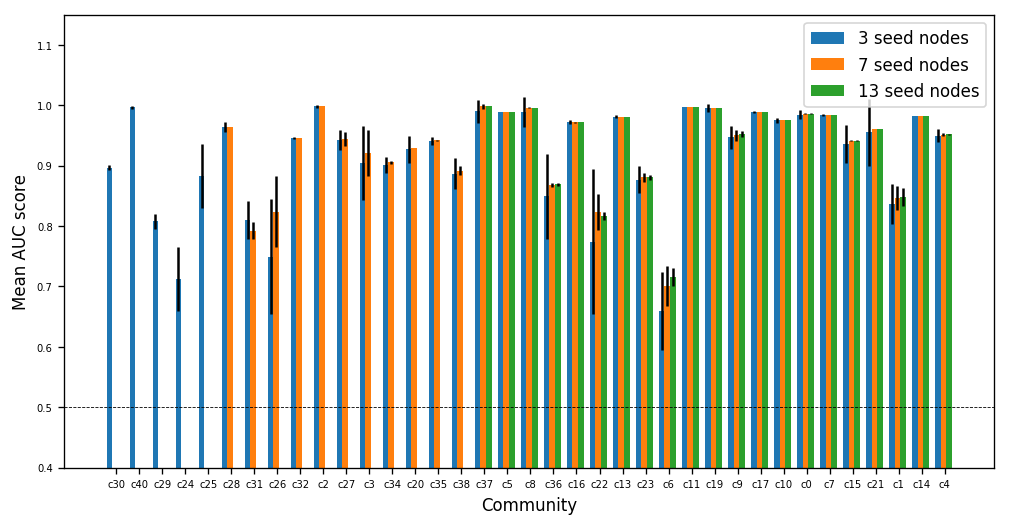

In [36]:
width=0.25

sorted_comms = sorted([c for c in comms if len(comms[c]) > 3], key=lambda x: len(comms[x]))
ind = np.arange(len(sorted_comms))
fig, ax = plt.subplots()



for i, s in enumerate(seed_sizes):
    ind_x = ind  + (i* width)
    means = [aucs[c][s] for c in sorted_comms]
    err = [stds[c][s] for c in sorted_comms]
    rects = ax.bar(ind_x, means, width, yerr=err, label='{} seed nodes'.format(s))

    
fig.set_dpi(120)
fig.set_size_inches(10, 5)
    
ticks = ax.set_xticklabels(["c{}".format(c) for c in sorted_comms])

ax.set_ylabel("Mean AUC score")
ax.set_xlabel("Community")
ax.set_xticks(ind + 0.3)
ax.set_ylim((0.4, 1.15))
ax.axhline(0.5, linestyle='--', color='#000000', linewidth=0.5)
ax.tick_params(labelsize=6)
ax.legend()

fig.savefig('eu_roc_scores.svg')
fig.savefig('eu_roc_scores.eps')
fig.savefig('eu_roc_scores.png')

In [41]:
print(len([c for c in comms if len(comms[c]) > 3]))

37


In [59]:
node_comms = defaultdict(list)

for c, com in comms.items():
    for node in com:
        node_comms[node] += com

for node in node_comms:
    node_comms[node] = list(set(node_comms[node]))

In [42]:
# Calculate the relatedness score for individual nodes in our dataset
node_wise_mu_i = dict()

def mui_n(node):
    vec, key = mu_ivector(graph, index, [node])
    return node, vec, key

vecs = Parallel(n_jobs=24) ( delayed(mui_n)(node) for node in node_comms)

for n, v, k in vecs:
    node_wise_mu_i[n] = (v,k)

0.9044518190268608


<Container object of 986 artists>

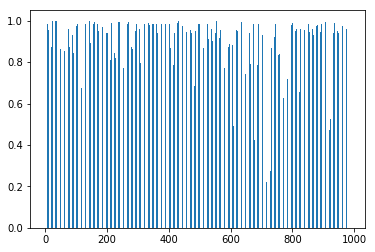

In [65]:
# Binary classification for each node
def roc_score_node(n):
    vec, key = node_wise_mu_i[n]
    inc = lambda x: 1 if x in node_comms[n] else 0
    y_true = [inc(x) for x in graph.nodes()]
    y_score = [vec[key[x]] for x in graph.nodes()]
    return roc_auc_score(y_true, y_score)


nwise_roc_scores = Parallel(n_jobs=24) ( delayed(roc_score_node)(node) for node in node_comms)

print(np.mean(nwise_roc_scores))
plt.bar(np.arange(len(nwise_roc_scores)), roc_scores, 0.4)

In [63]:
# Binary classification for each node

def roc_score_node(n, vec, key):
    inc = lambda x: 1 if x in node_comms[n] else 0
    y_true = [inc(x) for x in graph.nodes()]
    y_score = [vec[key[x]] for x in graph.nodes()]
    curve = roc_curve(y_true, y_score)
    return curve


nwise_roc_curves = Parallel(n_jobs=24) ( delayed(roc_score_node)(node, *node_wise_mu_i[node]) for node in node_comms if len(node_comms[node]) > 1) 


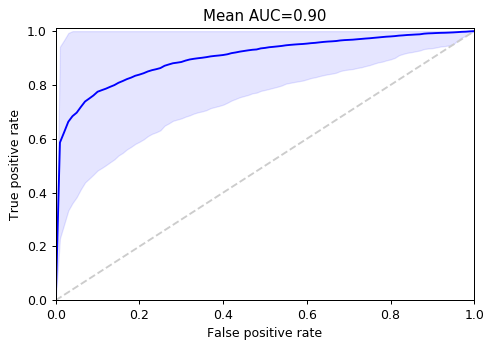

In [67]:
fig, ax = plt.subplots()
fig.set_dpi(90)


ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.01])

tprs = []
base_fpr = np.linspace(0, 1, 101)

for fpr,tpr,_ in nwise_roc_curves:
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--', color="#cccccc")
ax.plot(base_fpr, mean_tprs, color="b")
ax.fill_between(base_fpr, tprs_lower, tprs_upper, color="b", alpha=0.1)
ax.set_title("Mean AUC={:.2f}".format(np.mean(nwise_roc_scores)))

fig.savefig("figs/eu_email_nodewise_roc.eps")
fig.savefig("figs/eu_email_nodewise_roc.svg")
fig.savefig("figs/eu_email_nodewise_roc.png")


In [68]:
print(len(node_comms))

986


In [44]:

for s in seed_sizes:
    for c in aucs[c]:

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


NameError: name 'aucs' is not defined